In [25]:
!pip install pretty_midi
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils

from typing import Dict, List, Optional, Sequence, Tuple
import collections
import subprocess, os, platform
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import music21
from torchsummary import summary

from tqdm import tqdm, trange

from IPython import display
from matplotlib import pyplot as plt
import seaborn as sns

In [27]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(use_cuda)

False


In [28]:
!wget https://github.com/RuslansAleksejevs/RNN-music-generation/blob/main/MIDI/bwv1013.zip

#!wget https://github.com/RuslansAleksejevs/RNN-music-generation/blob/main/MIDI/King%20Porter%20Stomp.mid

In [29]:
!unzip /content/bwv1013.zip # If it gives an error

Archive:  /content/bwv1013.zip
  inflating: fp-1all.mid             
  inflating: fp-3sar.mid             
  inflating: fp-2cou.mid             
  inflating: fp-4bou.mid             


In [30]:
data_dir = pathlib.Path('/content/')

filenames = glob.glob(str(data_dir / '*.mid*'))
print(data_dir)
print('Number of files:', len(filenames))
if(len(filenames)==0):
    print("\n")
    print("ERROR and SOLUTION:\nError occured while unzipping 'bwv1013.zip'. Just take this file from the repository and upload to colab manually -- then everything will start to work.")

/content
Number of files: 4


In [31]:
majors = dict(
    [("G#", 4), ("A-", 4), ("A", 3), ("B-", 3), ("B", 2), ("B#", 1), ("C", 0), ("C#", -1), ("D-", -1), ("D", -2),
     ("D#", -3), ("E-", -3), ("E", -4), ("F", -5), ("F#", 6), ("G-", 6), ("G", 5)])
minors = dict(
    [("G#", 1), ("A-", 1), ("A", 0), ("B-", 0), ("B", -1), ("B#", -2), ("C", -3), ("C#", -4), ("D-", -4), ("D", -5),
     ("D#", 6), ("E-", 6), ("E", 5), ("F", 4), ("F#", 3), ("G-", 3), ("G", 2)])


def transposer(file):
    score = music21.converter.parse(file)
    key = score.analyze('key')
    # print(key)
    if key.mode == "major":
        halfSteps = majors[key.tonic.name]

    elif key.mode == "minor":
        halfSteps = minors[key.tonic.name]

    newscore = score.transpose(halfSteps)
    key = newscore.analyze('key')
    # print(key.tonic.name, key.mode)
    newFileName = file[-4:] + '_C_.mid'
    newscore.write('mid', newFileName)


In [32]:
# analyzing and working with a sample file

sample_file = filenames[0]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

# Extracting the notes
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name}, duration={duration:.4f}')

/content/fp-4bou.mid
Number of instruments: 1
Instrument name: Flute
0: pitch=76, note_name=E5, duration=0.3750
1: pitch=69, note_name=A4, duration=0.1813
2: pitch=71, note_name=B4, duration=0.1813
3: pitch=72, note_name=C5, duration=0.3687
4: pitch=71, note_name=B4, duration=0.1813
5: pitch=69, note_name=A4, duration=0.1813
6: pitch=68, note_name=G#4, duration=0.3688
7: pitch=69, note_name=A4, duration=0.3688
8: pitch=76, note_name=E5, duration=0.3688
9: pitch=76, note_name=E5, duration=0.7438


In [33]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    # transposer(midi_file)
    pm = pretty_midi.PrettyMIDI(midi_file)
    notes = collections.defaultdict(list)
    for instrument in pm.instruments:
        sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
        prev_start = sorted_notes[0].start
        for note in sorted_notes:
            start = note.start
            end = note.end
            notes['pitch'].append(note.pitch)
            notes['start'].append(start)
            notes['end'].append(end)
            notes['step'].append(start - prev_start)
            notes['duration'].append(end - start)
            prev_start = start
        break
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [34]:
raw_notes = midi_to_notes(sample_file)
raw_notes

,pitch,start,end,step,duration
0,76,1.1250,1.50000,0.0000,0.37500
1,69,1.5000,1.68125,0.3750,0.18125
2,71,1.6875,1.86875,0.1875,0.18125
3,72,1.8750,2.24375,0.1875,0.36875
4,71,2.2500,2.43125,0.3750,0.18125
...,...,...,...,...,...
524,84,132.7500,132.93750,0.1875,0.18750
525,83,132.9375,133.12500,0.1875,0.18750
526,81,133.1250,133.31250,0.1875,0.18750
527,80,133.3125,133.50000,0.1875,0.18750


In [35]:
# Converting to note names by considering the respective pitch values

get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
print(sample_note_names[:10])


# Visualizing the paramaters of the muscial notes of the piano

def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])

        plt.figure(figsize=(20, 4))
        plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
        plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)

        plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
        plt.xlabel('Time [s]')
        plt.ylabel('Pitch')
        _ = plt.title(title)
        plt.show()

['E5' 'A4' 'B4' 'C5' 'B4' 'A4' 'G#4' 'A4' 'E5' 'E5']


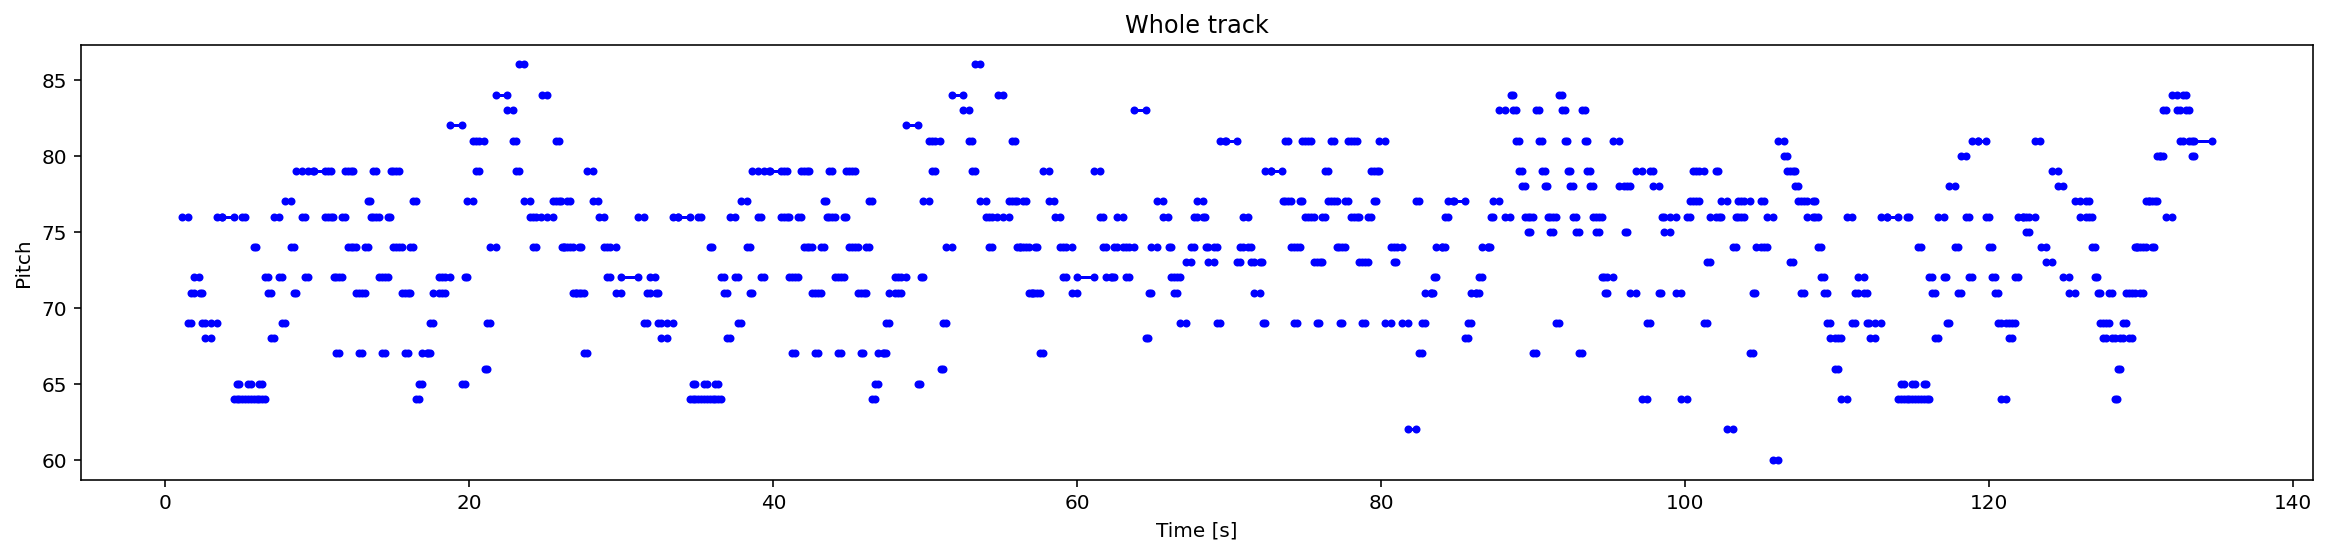

In [36]:
plot_piano_roll(raw_notes)

In [37]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str,
                  velocity: int = 100) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])

        note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']),
                                start=start, end=end)
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm


example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [38]:
print(filenames)

['/content/fp-4bou.mid', '/content/fp-1all.mid', '/content/fp-2cou.mid', '/content/fp-3sar.mid']


In [39]:
num_files = 1
all_notes = []
# filenames = glob.glob(str(data_dir / '*.mid*'))
for f in tqdm(filenames[:num_files]):
    # print(f)
    notes = midi_to_notes(f)
    all_notes.append(notes)
# notes = midi_to_notes('/content/blabla.mid')
# all_notes.append(notes)


# all_notes = pd.concat(all_notes)

# n_notes = len(pd.concat(all_notes))
# print('Number of notes parsed:', n_notes)


100%|██████████| 1/1 [00:00<00:00, 52.96it/s]


In [40]:
# filenames[2]

In [41]:
max_pitch, max_step, max_duration = 0, 0, 0
for n in all_notes:
    max_pitch = max(max_pitch, n['pitch'].max())
    max_step = max(max_step, n['step'].max())
    max_duration = max(max_duration, n['duration'].max())
max_pitch = 128
print(max_pitch, max_step, max_duration)

128 1.125 1.125


In [42]:
key_order = ['pitch', 'step', 'duration']
train_notes = []
for i in range(len(all_notes)):
    s = np.stack([all_notes[i][key] for key in key_order], axis=1)
    if s.shape[0] > 100:
        print(i, s.shape)
        train_notes.append(torch.Tensor(s[:, :]).reshape((s.shape[0], s.shape[1])))

print(len(train_notes))
# notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
# print(notes_ds.element_spec)

# dataset = data_utils.TensorDataset(torch.Tensor(train_notes))
# print(len(dataset))

0 (529, 3)
1


In [43]:
def round_to(x, n):
    return torch.round(x / n) * n


def scalar_to_vector(scalar, mask, harm=0):
    return 1. * ((mask - scalar) % harm == 0)

# print(scalar_to_vector(65, np.arange(128)))

In [44]:
seq_length = 11
vocab_size = 128
note_n = 1

def windowizer(data_tensor, seq_length, vocab_size, step=1):
    shape = data_tensor.shape
    data_tensor = torch.mul(data_tensor,
                            torch.Tensor([[1. / max_pitch, 1. / max_step, 1. / max_duration] for i in range(shape[0])]))
    windows = data_tensor.reshape(-1).unfold(0, seq_length * shape[1], step * shape[1])
    sequences = windows.reshape((shape[0] - seq_length + 1, seq_length, shape[1]))
    x, y = torch.empty(0), torch.empty(0)
    for vector in sequences:
        x = torch.cat((x, vector[:10]))
        y = torch.cat((y, vector[10:]))

    return x.reshape((shape[0] - seq_length + 1, seq_length - note_n, shape[1])), \
           y.reshape(shape[0] - seq_length + 1, note_n, shape[1])


songs_x, songs_y = [], []
for i in range(len(train_notes)):
    x, y = windowizer(train_notes[i], seq_length, vocab_size)
    songs_x.append(x)
    songs_y.append(y)
print(songs_x[0].shape, songs_y[0].shape)


torch.Size([519, 10, 3]) torch.Size([519, 1, 3])


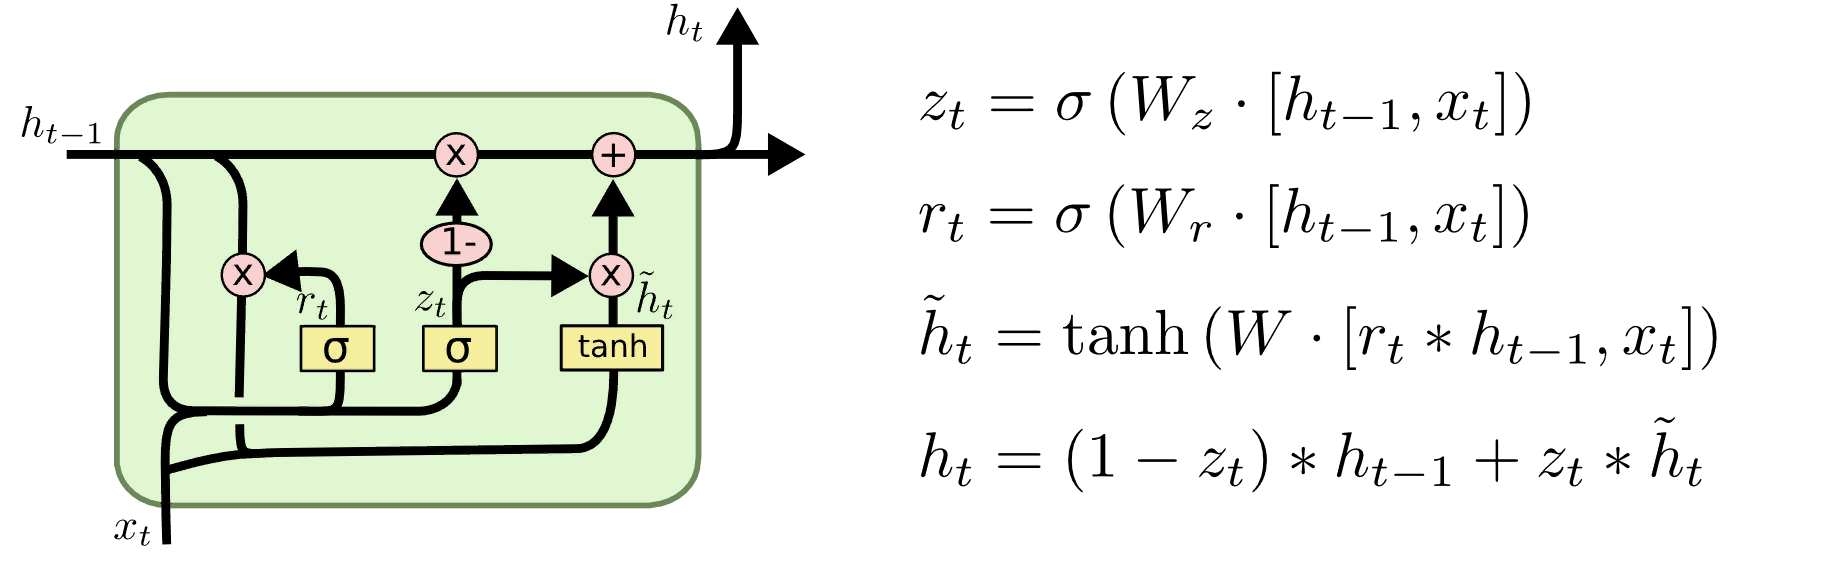

In [45]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.W_z = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size, requires_grad=True) * 0.1)
        self.W_r = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size, requires_grad=True) * 0.1)
        self.W = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size, requires_grad=True) * 0.1)
        self.h0 = nn.Parameter(torch.zeros((hidden_size), requires_grad=True))

    def forward(self, x, h=None):  # Without a batch dimension
        if h is None:
            h = self.h0
        # print(h.shape, x.shape)
        z = torch.sigmoid(self.W_z @ torch.cat((h, x)))
        r = torch.sigmoid(self.W_r @ torch.cat((h, x)))
        h_ = torch.tanh(self.W @ torch.cat((r * h, x)))
        h = (1 - z) * h + z * h_
        return h


class GRULayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.gru_cell = GRUCell(input_size, hidden_size)

    # Without a batch dimension x have sahape seq_len * input_size
    def forward(self, x, h=None):
        all_h = []
        for i in range(x.shape[0]):
            h = self.gru_cell(x[i], h)
            all_h.append(h)
        return torch.stack(all_h), h


class GRU_Network(nn.Module):
    def __init__(self, input_size, hidden_size):
        # hidden_size == number of neurons 
        super().__init__()
        self.rnn1 = GRULayer(input_size=3, hidden_size=hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.act = nn.Sigmoid()
        self.l1 = nn.Linear(hidden_size, note_n * 16)
        self.l2 = nn.Linear(hidden_size, note_n * 1)
        self.l3 = nn.Linear(hidden_size, note_n * 1)
        self.l4 = nn.Linear(hidden_size, note_n * 1)

    def forward(self, x):
        out, h = self.rnn1(x)
        # print(torch.cat((h1, h2, h3)))
        pitch = self.dropout(self.l1(h)).reshape(note_n, 16)
        step = self.dropout(self.l2(h)).reshape(note_n, 1)
        duration = self.dropout(self.l3(h)).reshape(note_n, 1)
        up_down = self.act(self.dropout(self.l4(h)))

        return pitch, step, duration, up_down

In [46]:
def sequence_to_distr(tensor, last_note):
    out = []
    for note in tensor:
        # print((note[0] - last_note) * 128)
        pitch_distr = scalar_to_vector(torch.round((note[0] - last_note) * 128),
                                       torch.arange(16), harm = 3)
        up_down = (torch.sign((note[0] - last_note)) + 1) / 2.
        # step_distr = scalar_to_vector(note[1], torch.arange(0, 1, 0.1/max_step))
        # dur_distr = scalar_to_vector(note[2], torch.arange(0, 1, 0.1/max_duration))
        out.append([pitch_distr, note[1], note[2], up_down])
        last_note = note[0]
    return out

def sum_losses(y, target, criterion, criterion2):
    loss = 0
    for i in range(note_n):
        # print(y[i * l: i * l + 128])
        # print(target[i][0])
        # print(y[i][0].shape)
        loss += criterion(y[0][i], target[i][0])
        loss += criterion(y[1][i], target[i][1])
        loss += criterion(y[2][i], target[i][2])
        loss += criterion2(y[3][i], target[i][3])
    return loss

In [47]:
def train(model):
    num_epochs = 30
    learning_rate = 0.001

    criterion = torch.nn.MSELoss().to(device)
    criterion2 = torch.nn.HingeEmbeddingLoss().to(device)

    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    total_loss = []
    for epoch in tqdm(range(num_epochs)):
        losses = np.empty(0)
        for j in (range(len(songs_x))):
            for i in range(songs_x[j].shape[0]):
                y = model(songs_x[j][i])
                optimizer.zero_grad()
                target = sequence_to_distr(songs_y[j][i], songs_x[j][i][-1][0])
                loss = sum_losses(y, target, criterion, criterion2)

                # loss += criterion2(step, songs_y[j, i, 1])
                # loss += criterion3(duration, songs_y[j, i, 2])
                losses = np.append(losses, loss.item())
                loss.backward()

                optimizer.step()
        total_loss.append(np.mean(losses))
        # if epoch % 5 == 0:
        #     print("Epoch: %d, loss: %1.5f" % (epoch, np.mean(losses)))
    return total_loss


input_size = 3
hidden_size = 10
rnn = GRU_Network(input_size, hidden_size).to(device)
# summary(rnn, (10, 3), batch_size=0)
losseses = train(rnn)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 30/30 [01:29<00:00,  2.98s/it]


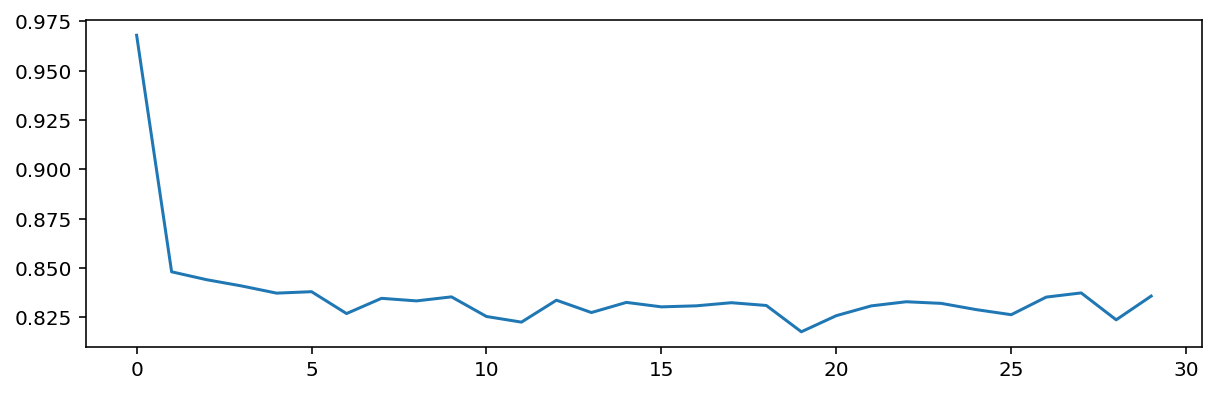

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(losseses)
plt.show()

In [49]:
def out_to_notes(y, last_note):
    out = torch.empty(0)
    for i in range(note_n):
        # print(torch.argmax(y[0][i]).item())
        print(y[3][i])
        out = torch.cat((out,
                         torch.Tensor([((last_note * 128 + (torch.round(y[3][i]) * 2 - 1)*torch.argmax(y[0][i]).item())) % 128 / 128.,
                                           y[1][i], y[2][i]])))
    return out
# print(out)

In [50]:
rnn.eval()
data_ = torch.mul(songs_x[0][0], torch.Tensor([[1.0, 1.0, 1.0]
                                              for i in range(songs_x[0][0].shape[0])]))
# print(data_[:, 0].shape)
for i in range(80):
    # print(data_.shape)
    out = rnn(data_[i: i + note_n])
    out = out_to_notes(out, data_[-1, 0])
    # print(out)
    data_ = torch.cat((data_, out.detach().cpu().reshape((note_n, 3))))

    # break
    # print(pitch, step, duration)

print(data_.shape)

tensor(0.0024, grad_fn=<SelectBackward0>)
tensor(0.0023, grad_fn=<SelectBackward0>)
tensor(0.0024, grad_fn=<SelectBackward0>)
tensor(0.0024, grad_fn=<SelectBackward0>)
tensor(0.0022, grad_fn=<SelectBackward0>)
tensor(0.0025, grad_fn=<SelectBackward0>)
tensor(0.0026, grad_fn=<SelectBackward0>)
tensor(0.0023, grad_fn=<SelectBackward0>)
tensor(0.0020, grad_fn=<SelectBackward0>)
tensor(0.0022, grad_fn=<SelectBackward0>)
tensor(0.0019, grad_fn=<SelectBackward0>)
tensor(0.0020, grad_fn=<SelectBackward0>)
tensor(0.0020, grad_fn=<SelectBackward0>)
tensor(0.0019, grad_fn=<SelectBackward0>)
tensor(0.0020, grad_fn=<SelectBackward0>)
tensor(0.0020, grad_fn=<SelectBackward0>)
tensor(0.0019, grad_fn=<SelectBackward0>)
tensor(0.0019, grad_fn=<SelectBackward0>)
tensor(0.0019, grad_fn=<SelectBackward0>)
tensor(0.0017, grad_fn=<SelectBackward0>)
tensor(0.0020, grad_fn=<SelectBackward0>)
tensor(0.0020, grad_fn=<SelectBackward0>)
tensor(0.0020, grad_fn=<SelectBackward0>)
tensor(0.0020, grad_fn=<SelectBack

In [51]:
data__ = torch.mul(data_, torch.Tensor([[max_pitch - 1, 1.0, 1.0] for i in range(data_.shape[0])]))

In [52]:
notes_pd = pd.DataFrame(np.abs(data__.numpy()), columns=['pitch', 'step', 'duration'])
print(notes_pd)

        pitch      step  duration
0   75.406250  0.000000  0.333333
1   68.460938  0.333333  0.161111
2   70.445312  0.166667  0.161111
3   71.437500  0.166667  0.327778
4   70.445312  0.333333  0.161111
..        ...       ...       ...
85  75.406250  0.339810  0.216160
86  75.406250  0.339810  0.216160
87  75.406250  0.339810  0.216160
88  75.406250  0.339810  0.216160
89  75.406250  0.339810  0.216160

[90 rows x 3 columns]


In [53]:
# plot_piano_roll(notes_pd)

In [54]:
out_file = '/content/result.mid'
out_pm = notes_to_midi(
    notes_pd, out_file=out_file, instrument_name=instrument_name)
# files.download('output.mid')
if platform.system() == 'Darwin':  # macOS
    subprocess.call(('open', out_file))